<a href="https://colab.research.google.com/github/Matthew-AI-Dev/emo_extractor/blob/master/Custom_Emoji_Generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Input,Lambda,Dense
from keras.models import Model
import keras.backend as K
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
text_data_path_1 = '/content/drive/My Drive/Colab Notebooks/INSIGHT_project/text_data_1.csv'
text_data_path_2 = '/content/drive/My Drive/Colab Notebooks/INSIGHT_project/text_data_2.data'

In [ ]:
df_1 = pd.read_csv(text_data_path_1)
print('number of dataset: {}'.format(df_1.shape[0]))
print('emotion types: {} types\n{}'.format(df_1['sentiment'].nunique(),df_1['sentiment'].unique()))
df_1.head()

number of dataset: 40000
emotion types: 13 types
['empty' 'sadness' 'enthusiasm' 'neutral' 'worry' 'surprise' 'love' 'fun'
 'hate' 'happiness' 'boredom' 'relief' 'anger']


,tweet_id,sentiment,author,content
0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!
4,1956968416,neutral,xkilljoyx,@dannycastillo We want to trade with someone w...


In [ ]:
df_2 = pd.read_csv(text_data_path_2)
print('number of dataset: {}'.format(df_2.shape[0]))
print('emotion types: {} types\n{}'.format(df_2['emotions'].nunique(),df_2['emotions'].unique()))
df_2.head()

number of dataset: 416809
emotion types: 6 types
['sadness' 'joy' 'love' 'anger' 'fear' 'surprise']


,Unnamed: 0,text,emotions
0,27383,i feel awful about it too because it s my job ...,sadness
1,110083,im alone i feel awful,sadness
2,140764,ive probably mentioned this before but i reall...,joy
3,100071,i was feeling a little low few days back,sadness
4,2837,i beleive that i am much more sensitive to oth...,love


In [ ]:
df_1_col_tokeep = ['sentiment','content']
df_1_sentiment_filter = ['worry','sadness','love','surprise','fun','hate','anger']
df_1 = df_1[df_1_col_tokeep]
df_1 = df_1[df_1['sentiment'].isin(df_1_sentiment_filter)]
df_1 = df_1.rename(columns = {"sentiment": "emotions","content":"text"}) 

emotion_rename = {'worry':'fear','fun':'joy','hate':'anger'}
df_1 = df_1.replace({'emotions':emotion_rename})

In [ ]:
def text_preprocessing(text):
    new_text = ' '.join(x for x in text.strip().lower().split() if not x.startswith('@'))
    new_text = ' '.join('website' if x.startswith('http://') else x for x in new_text.split())
    return new_text         

In [ ]:
df_1['text'] = df_1['text'].apply(text_preprocessing)
df_2['text'] = df_2['text'].apply(text_preprocessing)
df_2 = df_2[['emotions','text']]

In [ ]:
df = pd.concat([df_1,df_2])
df = df.reset_index(drop=True)

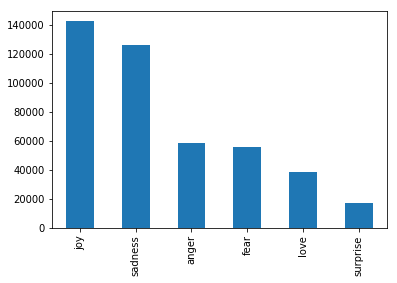

In [ ]:
df['emotions'].value_counts().plot.bar()

In [ ]:
X = df['text'].tolist()
y = df['emotions'].tolist()
emotion_type = np.unique(y)

In [ ]:
# X = np.asarray(X)
X = np.array(X, dtype=object)[:, np.newaxis]
y = np.asarray(pd.get_dummies(y),dtype=np.int8)

In [ ]:
X_train,X_valid_test,y_train,y_valid_test = train_test_split(X,y,test_size=0.05,random_state=0,stratify=y)
X_valid,X_test,y_valid,y_test = train_test_split(X_valid_test,y_valid_test,test_size=0.5,random_state=0,stratify=y_valid_test)
print('X_train shape: {}'.format(len(X_train)))
print('y_train shape: {}'.format(len(y_train)))
print('X_valid shape: {}'.format(len(X_valid)))
print('y_valid shape: {}'.format(len(y_valid)))
print('X_test shape: {}'.format(len(X_test)))
print('y_test shape: {}'.format(len(y_test)))

X_train shape: 417687
y_train shape: 417687
X_valid shape: 10992
y_valid shape: 10992
X_test shape: 10992
y_test shape: 10992


In [ ]:
def USE(x):
    return embed(tf.squeeze(tf.cast(x, tf.string)), 
    	signature="default", as_dict=True)["default"]

In [ ]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/3"
# Import the Universal Sentence Encoder's TF Hub module
embed = hub.Module(module_url)

In [ ]:
input_text = Input(shape=(1,), dtype=tf.string)
embedding = Lambda(USE,output_shape=(512,))(input_text)
dense = Dense(256, activation='relu')(embedding)
pred = Dense(df['emotions'].nunique(),activation='softmax')(dense)
model = Model(inputs=[input_text],outputs=pred)
model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [ ]:
test_idx = 150

In [ ]:
X[test_idx]

array(['had to cancel wow for now'], dtype=object)

In [ ]:
emotion_type[np.argmax(y[test_idx])]

'sadness'

In [ ]:
with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer())
    session.run(tf.tables_initializer())
    history = model.fit(X_train,y_train,
              validation_data=(X_valid,y_valid),
              epochs=5,batch_size=64,shuffle=True)
    model.save_weights('./model.h5')

Train on 417687 samples, validate on 10992 samples
Epoch 1/5
417687/417687 [==============================] - 648s 2ms/step - loss: 0.9286 - acc: 0.6529 - val_loss: 0.8450 - val_acc: 0.6812
Epoch 2/5
417687/417687 [==============================] - 649s 2ms/step - loss: 0.8050 - acc: 0.6976 - val_loss: 0.7968 - val_acc: 0.6995
Epoch 3/5
417687/417687 [==============================] - 647s 2ms/step - loss: 0.7639 - acc: 0.7132 - val_loss: 0.7777 - val_acc: 0.7054
Epoch 4/5
417687/417687 [==============================] - 635s 2ms/step - loss: 0.7389 - acc: 0.7218 - val_loss: 0.7620 - val_acc: 0.7152
Epoch 5/5
417687/417687 [==============================] - 640s 2ms/step - loss: 0.7211 - acc: 0.7279 - val_loss: 0.7591 - val_acc: 0.7163


In [ ]:
new_text = ["In what year did the titanic sink ?", 
            "What is the highest peak in California ?", 
            "Who invented the light bulb ?"]

new_text = np.array(new_text, dtype=object)[:, np.newaxis]
with tf.Session() as session:
  K.set_session(session)
  session.run(tf.global_variables_initializer())
  session.run(tf.tables_initializer())
  model.load_weights('./model.h5')  
  predicts = model.predict(X_test, batch_size=32)

# categories = df_train.label.cat.categories.tolist()
# predict_logits = predicts.argmax(axis=1)
# predict_labels = [categories[logit] for logit in predict_logits]
# print(predict_labels)

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f3505a03748>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1473, in __del__
    self._session._session, self._handle)
tensorflow.python.framework.errors_impl.CancelledError: (None, None, 'Session has been closed.')


In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
confusion_matrix(np.argmax(y_test,axis=1),np.argmax(predicts,axis=1))

array([[1047,   71,   75,   22,  248,    5],
       [  76,  884,  130,   31,  241,   43],
       [  69,  107, 2856,  177,  339,   23],
       [  31,   18,  341,  451,  112,    7],
       [ 172,  188,  180,   61, 2548,   10],
       [  12,   74,  103,   21,   66,  153]])

In [ ]:
print(classification_report(np.argmax(y_test,axis=1),np.argmax(predicts,axis=1)))

              precision    recall  f1-score   support

           0       0.74      0.71      0.73      1468
           1       0.66      0.63      0.64      1405
           2       0.78      0.80      0.79      3571
           3       0.59      0.47      0.52       960
           4       0.72      0.81      0.76      3159
           5       0.63      0.36      0.46       429

    accuracy                           0.72     10992
   macro avg       0.69      0.63      0.65     10992
weighted avg       0.72      0.72      0.72     10992



## Spliting Joy and Sadness by half

In [ ]:
len(df)

439671

In [ ]:
df_joy_temp = df[df['emotions']=='joy']
df_sadness_temp = df[df['emotions']=='sadness']
df_anger_temp = df[df['emotions']=='anger']
df_fear_temp = df[df['emotions']=='fear']
df_love_temp = df[df['emotions']=='love']
from sklearn.utils import shuffle

df_joy_temp = shuffle(df_joy_temp)#.sample(frac=1).reset_index(drop=True)
df_sadness_temp = shuffle(df_sadness_temp)#.sample(frac=1).reset_index(drop=True)
df_anger_temp = shuffle(df_anger_temp)#.sample(frac=1).reset_index(drop=True)
df_fear_temp = shuffle(df_fear_temp)#.sample(frac=1).reset_index(drop=True)
df_love_temp = shuffle(df_love_temp)#.sample(frac=1).reset_index(drop=True)

df_joy_temp = df_joy_temp[1:int(np.ceil(len(df_joy_temp)/7))]
df_sadness_temp = df_sadness_temp[1:int(np.ceil(len(df_sadness_temp)/6))]
df_anger_temp = df_anger_temp[1:int(np.ceil(len(df_anger_temp)/3))]
df_fear_temp = df_fear_temp[1:int(np.ceil(len(df_fear_temp)/3))] 
df_love_temp = df_love_temp[1:int(np.ceil(len(df_love_temp)/2))] 
df_rest_temp = df[df['emotions']=='surprise']

In [ ]:
df = pd.concat([df_joy_temp,df_sadness_temp,df_anger_temp,df_fear_temp,df_love_temp,df_rest_temp])
df = shuffle(df)#.sample(frac=1).reset_index(drop=True)

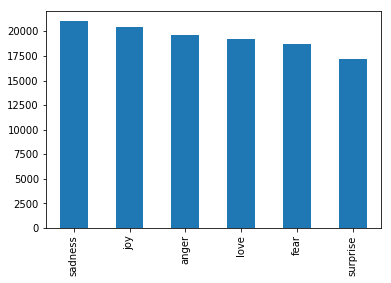

In [ ]:
df['emotions'].value_counts().plot.bar()

In [ ]:
X = df['text'].tolist()
y = df['emotions'].tolist()
emotion_type = np.unique(y)

In [ ]:
X = np.array(X, dtype=object)[:, np.newaxis]
y = np.asarray(pd.get_dummies(y),dtype=np.int8)

In [ ]:
X_train,X_valid_test,y_train,y_valid_test = train_test_split(X,y,test_size=0.05,random_state=0,stratify=y)
X_valid,X_test,y_valid,y_test = train_test_split(X_valid_test,y_valid_test,test_size=0.5,random_state=0,stratify=y_valid_test)
print('X_train shape: {}'.format(len(X_train)))
print('y_train shape: {}'.format(len(y_train)))
print('X_valid shape: {}'.format(len(X_valid)))
print('y_valid shape: {}'.format(len(y_valid)))
print('X_test shape: {}'.format(len(X_test)))
print('y_test shape: {}'.format(len(y_test)))

X_train shape: 110319
y_train shape: 110319
X_valid shape: 2903
y_valid shape: 2903
X_test shape: 2904
y_test shape: 2904


In [ ]:
input_text = Input(shape=(1,), dtype=tf.string)
embedding = Lambda(USE,output_shape=(512,))(input_text)
dense = Dense(256, activation='relu')(embedding)
pred = Dense(df['emotions'].nunique(),activation='softmax')(dense)
model = Model(inputs=[input_text],outputs=pred)
model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [ ]:
with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer())
    session.run(tf.tables_initializer())
    history = model.fit(X_train,y_train,
              validation_data=(X_valid,y_valid),
              epochs=5,batch_size=64,shuffle=True)
    model.save_weights('./model_balanced.h5')

Train on 110319 samples, validate on 2903 samples
Epoch 1/5
110319/110319 [==============================] - 177s 2ms/step - loss: 1.1601 - acc: 0.5590 - val_loss: 1.0800 - val_acc: 0.5846
Epoch 2/5
110319/110319 [==============================] - 173s 2ms/step - loss: 1.0166 - acc: 0.6151 - val_loss: 1.0068 - val_acc: 0.6080
Epoch 3/5
110319/110319 [==============================] - 172s 2ms/step - loss: 0.9461 - acc: 0.6447 - val_loss: 0.9574 - val_acc: 0.6307
Epoch 4/5
110319/110319 [==============================] - 169s 2ms/step - loss: 0.8985 - acc: 0.6638 - val_loss: 0.9350 - val_acc: 0.6466
Epoch 5/5
110319/110319 [==============================] - 168s 2ms/step - loss: 0.8636 - acc: 0.6771 - val_loss: 0.9211 - val_acc: 0.6604


In [ ]:
with tf.Session() as session:
  K.set_session(session)
  session.run(tf.global_variables_initializer())
  session.run(tf.tables_initializer())
  model.load_weights('./model_balanced.h5')  
  predicts = model.predict(X_test, batch_size=32)

In [ ]:
confusion_matrix(np.argmax(y_test,axis=1),np.argmax(predicts,axis=1))

array([[382,  29,  13,  19,  41,   5],
       [ 25, 289,  24,  30,  53,  47],
       [ 31,  30, 277,  95,  48,  30],
       [ 14,  22,  54, 321,  44,  25],
       [ 69,  60,  19,  37, 334,   8],
       [ 27,  37,  30,  46,  17, 272]])

In [ ]:
print(classification_report(np.argmax(y_test,axis=1),np.argmax(predicts,axis=1)))

              precision    recall  f1-score   support

           0       0.70      0.78      0.74       489
           1       0.62      0.62      0.62       468
           2       0.66      0.54      0.60       511
           3       0.59      0.67      0.62       480
           4       0.62      0.63      0.63       527
           5       0.70      0.63      0.67       429

    accuracy                           0.65      2904
   macro avg       0.65      0.65      0.65      2904
weighted avg       0.65      0.65      0.64      2904



## LSTM

In [ ]:
df.head()

,emotions,text
227807,love,i feel that sense of fond protectiveness for s...
376691,joy,i am number four download to feel the terrific...
391074,joy,i feel like im slowly losing my mind and my in...
240768,joy,i feel as if today isnt going to be completely...
75603,joy,i hope this means that you are on the mend and...


In [ ]:
len(df)

116126

In [ ]:
input_sentences = [text.split(" ") for text in df["text"].values.tolist()]
labels = df["emotions"].values.tolist()

In [ ]:
# Initialize word2id and label2id dictionaries that will be used to encode words and labels
word2id = dict()
label2id = dict()

max_words = 0 # maximum number of words in a sentence

# Construction of word2id dict
for sentence in input_sentences:
    for word in sentence:
        # Add words to word2id dict if not exist
        if word not in word2id:
            word2id[word] = len(word2id)
    # If length of the sentence is greater than max_words, update max_words
    if len(sentence) > max_words:
        max_words = len(sentence)
    
# Construction of label2id and id2label dicts
label2id = {l: i for i, l in enumerate(set(labels))}
id2label = {v: k for k, v in label2id.items()}
id2label

{0: 'sadness', 1: 'joy', 2: 'anger', 3: 'fear', 4: 'love', 5: 'surprise'}

In [ ]:
import keras
# Encode input words and labels
X = [[word2id[word] for word in sentence] for sentence in input_sentences]
Y = [label2id[label] for label in labels]

# Apply Padding to X
from keras.preprocessing.sequence import pad_sequences
X = pad_sequences(X, max_words)

# Convert Y to numpy array
Y = keras.utils.to_categorical(Y, num_classes=len(label2id), dtype='float32')

# Print shapes
print("Shape of X: {}".format(X.shape))
print("Shape of Y: {}".format(Y.shape))

Shape of X: (116126, 178)
Shape of Y: (116126, 6)


In [ ]:
embedding_dim = 100 # The dimension of word embeddings

# Define input tensor
sequence_input = keras.Input(shape=(max_words,), dtype='int32')

# Word embedding layer
embedded_inputs =keras.layers.Embedding(len(word2id) + 1,
                                        embedding_dim,
                                        input_length=max_words)(sequence_input)

# Apply dropout to prevent overfitting
embedded_inputs = keras.layers.Dropout(0.2)(embedded_inputs)

# Apply Bidirectional LSTM over embedded inputs
lstm_outs = keras.layers.wrappers.Bidirectional(
    keras.layers.LSTM(embedding_dim, return_sequences=True)
)(embedded_inputs)

# Apply dropout to LSTM outputs to prevent overfitting
lstm_outs = keras.layers.Dropout(0.2)(lstm_outs)

# Attention Mechanism - Generate attention vectors
input_dim = int(lstm_outs.shape[2]) ## may be ommitted 
permuted_inputs = keras.layers.Permute((2, 1))(lstm_outs) ## may be ommitted
attention_vector = keras.layers.TimeDistributed(keras.layers.Dense(1))(lstm_outs)
attention_vector = keras.layers.Reshape((max_words,))(attention_vector)
attention_vector = keras.layers.Activation('softmax', name='attention_vec')(attention_vector)
attention_output = keras.layers.Dot(axes=1)([lstm_outs, attention_vector])

# Last layer: fully connected with softmax activation
fc = keras.layers.Dense(embedding_dim, activation='relu')(attention_output)
output = keras.layers.Dense(len(label2id), activation='softmax')(fc)

# Finally building model
model = keras.Model(inputs=[sequence_input], outputs=output)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer='adam')

In [ ]:
with tf.Session() as session:
    K.set_session(session)
    history = model.fit(X, Y, epochs=2, batch_size=64, validation_split=0.1, shuffle=True)
    model.save_weights('./model_balanced_LSTM.h5')

Train on 104513 samples, validate on 11613 samples
Epoch 1/2
104513/104513 [==============================] - 1269s 12ms/step - loss: 0.5674 - acc: 0.7666 - val_loss: 0.2242 - val_acc: 0.9069
Epoch 2/2
104513/104513 [==============================] - 1275s 12ms/step - loss: 0.2075 - acc: 0.9179 - val_loss: 0.2193 - val_acc: 0.9121


In [ ]:
with tf.Session() as session:
  K.set_session(session)
  session.run(tf.global_variables_initializer())
  session.run(tf.tables_initializer())
  model.load_weights('./model_balanced_LSTM.h5')  
  predicts = model.predict(X[:1000], batch_size=32)

confusion_matrix(np.argmax(Y[:1000],axis=1),np.argmax(predicts,axis=1))

array([[179,   0,   1,   8,   0,   1],
       [  0, 170,   0,   0,  12,   4],
       [  2,   0, 168,   5,   0,   0],
       [  3,   0,   2, 143,   1,  15],
       [  0,   0,   0,   0, 136,   2],
       [  0,   1,   0,   1,   1, 145]])

In [ ]:
print(classification_report(np.argmax(Y[:1000],axis=1),np.argmax(predicts,axis=1)))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       189
           1       0.99      0.91      0.95       186
           2       0.98      0.96      0.97       175
           3       0.91      0.87      0.89       164
           4       0.91      0.99      0.94       138
           5       0.87      0.98      0.92       148

    accuracy                           0.94      1000
   macro avg       0.94      0.94      0.94      1000
weighted avg       0.94      0.94      0.94      1000



## BERT

In [ ]:
!git clone https://github.com/google-research/bert.git

Cloning into 'bert'...
remote: Enumerating objects: 333, done.
remote: Total 333 (delta 0), reused 0 (delta 0), pack-reused 333
Receiving objects: 100% (333/333), 282.45 KiB | 13.45 MiB/s, done.
Resolving deltas: 100% (183/183), done.


In [ ]:
df = df.reset_index()

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


le = LabelEncoder()
  
# Creating train and dev dataframes according to BERT
df_bert = pd.DataFrame({'user_id':df['index'],
            'label':le.fit_transform(df['emotions']),
            'alpha':['a']*df.shape[0],
            'text':df['text'].replace(r'\n',' ',regex=True)})
 
df_bert_train, df_bert_dev = train_test_split(df_bert, test_size=0.01)
 
# # Creating test dataframe according to BERT
# df_test = pd.read_csv("data/test.csv")
# df_bert_test = pd.DataFrame({'User_ID':df_test['User_ID'],
#                  'text':df_test['Description'].replace(r'\n',' ',regex=True)})



In [ ]:
df_bert.head()

,user_id,label,alpha,text
0,227807,3,a,i feel that sense of fond protectiveness for s...
1,376691,2,a,i am number four download to feel the terrific...
2,391074,2,a,i feel like im slowly losing my mind and my in...
3,240768,2,a,i feel as if today isnt going to be completely...
4,75603,2,a,i hope this means that you are on the mend and...


In [ ]:
!mkdir data

In [ ]:
# Saving dataframes to .tsv format as required by BERT
df_bert_train.to_csv('data/bert_train.tsv', sep='\t', index=False, header=False)
df_bert_dev.to_csv('data/bert_dev.tsv', sep='\t', index=False, header=False)
# df_bert_test.to_csv('data/test.tsv', sep='\t', index=False, header=True)

In [ ]:
!python run_classifier.py 
--task_name=cola 
--do_train=true 
--do_eval=true 
--do_predict=true 
--data_dir=./data/ 
--vocab_file=./uncased_L-12_H-768_A-12/vocab.txt 
--bert_config_file=./uncased_L-12_H-768_A-12/bert_config.json 
--init_checkpoint=./uncased_L-12_H-768_A-12/bert_model.ckpt 
--max_seq_length=400 
--train_batch_size=64 
--learning_rate=2e-5 
--num_train_epochs=2.0 
--output_dir=./bert_output/ 
--do_lower_case=False

SyntaxError: ignored